In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import optim

import math
import numpy as np
import pandas as pd
from arff2pandas import a2p
import io
from tqdm import tqdm

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
with open('Input/ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)
with open('Input/ECG5000_TEST.arff') as f:
  test = a2p.load(f)

In [5]:
train.shape, test.shape

((500, 141), (4500, 141))

In [6]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [7]:
df.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
932,-0.075320,-1.460589,-2.210008,-3.324593,-3.772989,-3.253793,-2.053299,-1.886267,-1.798518,-0.940286,...,0.824480,0.892933,1.115028,0.982992,0.546125,0.894318,1.119690,1.175811,0.555767,1
3418,-1.309141,-1.472702,-1.424500,-1.550974,-1.512701,-1.560284,-1.755986,-1.821289,-1.686459,-1.821780,...,1.727856,1.582580,1.380243,1.219691,1.535461,1.872220,1.045581,-0.434978,-2.337629,3
1234,-0.776901,-2.387049,-3.405666,-4.279135,-4.559530,-3.849366,-2.805222,-1.670297,-1.171902,-0.633994,...,0.635859,0.449270,-0.164469,-0.713304,-1.293700,-1.438508,-0.853304,-0.371484,-1.548866,1
2111,0.562906,-1.281825,-2.715639,-4.120316,-4.064032,-3.035556,-2.024838,-1.861001,-1.177858,-0.443848,...,1.675769,1.909459,1.464944,1.171435,0.998764,0.809484,0.524937,1.019959,1.497237,1
3317,0.514930,-0.477889,-1.290087,-2.133637,-2.782633,-3.166533,-3.253469,-2.959048,-2.470666,-1.912872,...,-1.569182,-2.213739,-2.674724,-3.030639,-3.374209,-3.183987,-2.193119,-1.158894,0.249414,2


In [8]:
col_dic={}
for col in df.columns:
    i=col.find('@')
    col_dic[col]=col[:i]

In [9]:
df.rename(columns=col_dic,inplace=True)

In [10]:
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

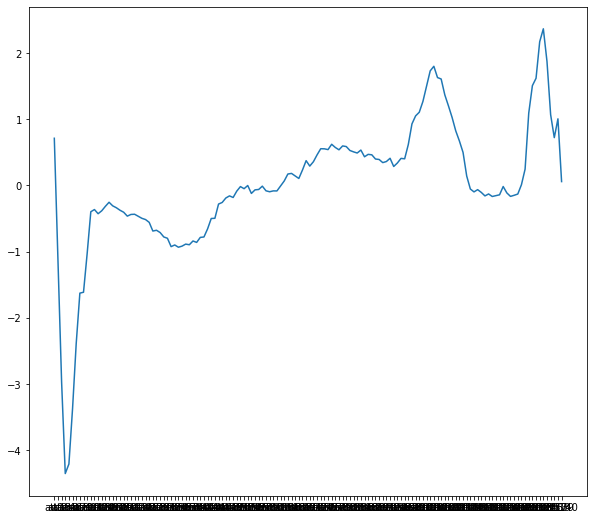

In [11]:
plt.figure(figsize=(10,9))
plt.plot(df.iloc[404,:-1])

<BarContainer object of 5 artists>

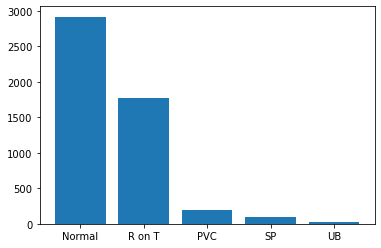

In [12]:
class_names = ['Normal','R on T','PVC','SP','UB']

plt.bar(class_names, df.target.value_counts())

# Data preparation

In [13]:
normal=df.loc[df.target=='1'].drop(columns=['target'])

In [14]:
anomaly=df.loc[df.target!='1'].drop(columns=['target'])

In [15]:
train_df, test_df=train_test_split(normal,test_size=0.15)

In [16]:
class MyDataset(Dataset):
    def __init__(self,X):
        self.x=X
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return torch.FloatTensor(self.x[index].reshape(-1,1))

In [17]:
train_ds=MyDataset(train_df.values)
test_ds=MyDataset(test_df.values)

In [18]:
anomaly_ds=MyDataset(anomaly.values)

In [19]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=12, shuffle=True, num_workers=6)
test_dl=torch.utils.data.DataLoader(test_ds, batch_size=12, shuffle=True, num_workers=6)

In [20]:
anomaly_dl=torch.utils.data.DataLoader(anomaly_ds, batch_size=12, shuffle=True, num_workers=6)

# Autoencoder Model

In [21]:
class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    #hidden_n.size= 1, batch size, embedding_dim
    hidden_n=hidden_n.squeeze(0).unsqueeze(1)
    #hidden_n.size=batch size,1,embedding_dim
    return hidden_n

class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)
    
  def forward(self, x):
    x = x.repeat(1,self.seq_len, self.n_features)
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    return self.output_layer(x)

class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim)
    self.decoder = Decoder(seq_len, embedding_dim, n_features)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

# Training

In [22]:
def train_fct(model, train_loader, epochs, criterion, optimizer, device):
    L=len(train_loader)
    model.train()
    for epoch in range(1, epochs + 1):
         # Make sure that the model is in training mode.

        total_loss = 0
        hidden = None
        for batch in tqdm(train_loader):
            # get data
                       
            batch= batch.to(device)
            optimizer.zero_grad()

            # get predictions from model
            pred = model(batch)
            
            # perform backprop
            loss = criterion( pred,batch)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data.item()
        
        if epoch%5==0:
            print("Epoch: {}, Loss: {}".format(epoch, total_loss /L))
        
def val_score(model,test_dl,criterion):
    total_loss = 0
    L=len(test_dl)
    model.eval()
    for batch in tqdm(test_dl):
        # get data
        
        batch= batch.to(device)

        # get predictions from model
        pred = model(batch)
        loss=criterion(pred,batch)
        total_loss += loss.data.item()
    
    return (total_loss/L)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device {}.".format(device))

Using device cuda.


In [24]:
model=RecurrentAutoencoder(seq_len=140,n_features=1,embedding_dim=128).to(device)
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [25]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss(reduction='mean')

In [26]:
train_fct(model,train_dl,20,criterion=criterion,optimizer=optimizer,device=device)

  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.3699456912595869


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.20604689671221563


  0%|          | 0/207 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.16135434075686092


100%|██████████| 207/207 [00:07<00:00, 26.55it/s]

Epoch: 20, Loss: 0.14335151229071733


In [27]:
val_score(model,test_dl,criterion)

100%|██████████| 37/37 [00:00<00:00, 53.06it/s]


0.14695544802659266

# Losses

In [28]:
def losses(model,data_loader):
    model.eval()
    ls=[]
    for b in data_loader:
        b=b.to(device)
        pred=model(b)
        loss=torch.abs(pred-b).squeeze(-1).mean(1)
        ls.append(loss)
    
    return torch.cat(ls).cpu().detach().numpy()

In [29]:
ls=losses(model,train_dl)

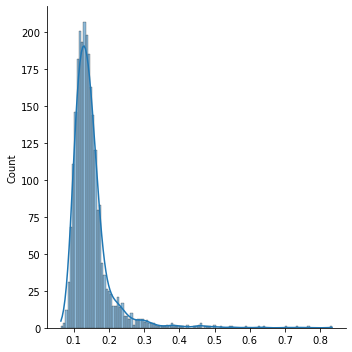

In [30]:
sns.displot(ls,kde=True)

In [31]:
ls=losses(model,test_dl)

/home/joao/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

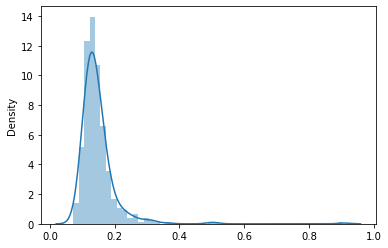

In [32]:
sns.distplot(ls,kde=True)

In [33]:
THRESHOLD=np.round(np.quantile(ls,0.99),3)
THRESHOLD

0.325

In [34]:
ls=losses(model,anomaly_dl)

/home/joao/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

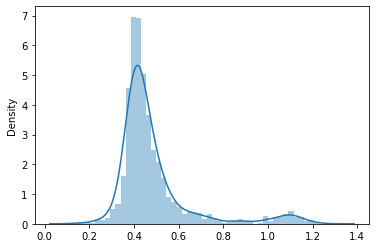

In [35]:
sns.distplot(ls)

In [36]:
(ls>THRESHOLD).mean()

0.9716482460355599